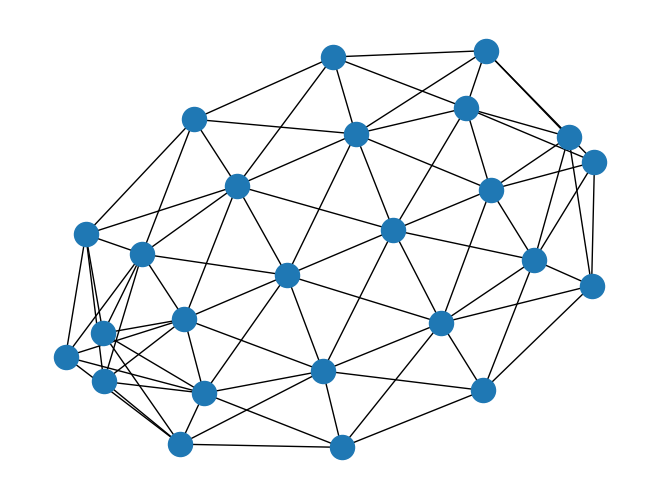

In [1]:

# conda install pytorch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -c pytorch -y & conda install pyg -c pyg -y & conda install -c anaconda networkx -y & conda install -c conda-forge matplotlib -y

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
from utils import *
from model import UpdateRule


height = 3
width = 5
hidden_dim = 10

n_inputs = 2
n_outputs = 3


update_rule = UpdateRule(
    n_inputs, 
    n_outputs,
    hidden_dim,
    8
)
update_rule.build_graph(
    height,
    width
)


# cuda_device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
cuda_device = torch.device("cpu")

update_rule = update_rule.to(cuda_device)

update_rule.draw()

In [5]:
from datasets import *
import copy
import numpy as np
np.set_printoptions(precision=1, suppress=True)


# dataset_loader = DataLoader(TranslateDataset(), batch_size=1, shuffle=True)

meta_set = MetaDataset()

optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)

best_loss = 10000
best_model = None

n_steps = 3
batch_size = 5
for epoch in range(10000):
    loss = 0
    for _ in range(batch_size):
        for set_idx in meta_set.iterate():
            update_rule.reset() 
            x = update_rule.initial_state(height, width)
            # for idx, (problem_data_x, problem_data_y) in enumerate(meta_set.get_set(set_idx)):
                
        
            x, batch_loss, network_output, correct = update_rule(x, n_steps, meta_set.get_set(set_idx))
            loss += batch_loss
                
           
            
    if loss < best_loss:
        # best_model = copy.deepcopy(update_rule)
        best_loss = loss
     
    loss /= batch_size   
    loss.backward()
    
    nn.utils.clip_grad_norm_(update_rule.parameters(), 1)
    optimizer.step()  
    optimizer.zero_grad()  
        
    print(f"""\r 
          Epoch {epoch * batch_size} |
          Loss {loss:.6} |
          Network out: {network_output} |
          Correct:  {correct}
        """.replace("\n", " ").replace("          ", ""), end="")
    
    print(f"\r Epoch {epoch * batch_size} | Loss {loss}", end="")
    if epoch % (200 // batch_size) == 0:
        print()


 Epoch 0 | Loss 2.287584066390991k out: [0.3 0.3 0.3] | Correct:  [0. 0. 1.]         
 Epoch 200 | Loss 2.28757381439209rk out: [0.3 0.3 0.3] | Correct:  [0. 0. 1.]         
 Epoch 400 | Loss 2.2227883338928223 out: [0.2 0.4 0.4] | Correct:  [0. 0. 1.]         
 Epoch 600 | Loss 2.158029317855835k out: [0.4 0.3 0.3] | Correct:  [1. 0. 0.]         
 Epoch 800 | Loss 2.182499408721924 out: [0. 1. 0.] | Correct:  [0. 0. 1.]             
 Epoch 1000 | Loss 2.2909111976623535 out: [0.5 0.3 0.3] | Correct:  [1. 0. 0.]         
 Epoch 1200 | Loss 2.289548635482788k out: [0.4 0.3 0.3] | Correct:  [0. 0. 1.]         
 Epoch 1400 | Loss 2.288832426071167k out: [0.4 0.3 0.3] | Correct:  [0. 0. 1.]         
 Epoch 1600 | Loss 2.2885069847106934 out: [0.4 0.3 0.3] | Correct:  [0. 0. 1.]         
 Epoch 1800 | Loss 2.288010835647583k out: [0.4 0.3 0.3] | Correct:  [0. 0. 1.]         
 Epoch 2000 | Loss 2.2876956462860107out: [0.4 0.3 0.3] | Correct:  [0. 0. 1.]          
 Epoch 2200 | Loss 2.2876973

KeyboardInterrupt: 

In [3]:
import numpy as np
np.set_printoptions(precision=3)

run_rule(torch.tensor([[0,0,0,1]]), update_rule)

TypeError: forward() missing 1 required positional argument: 'data'

In [ ]:

def run_rule_meta(update_rule, training, test, n_steps):
    x = update_rule.initial_state(height, width)
    for (problem_x, problem_y) in training:
        print(problem_x)
        for _ in range(n_steps):
            x = update_rule(x, problem_x.float(), problem_y.float())
            
            
    for _ in range(n_steps):
        x = update_rule(x, test.float())
        
    network_output = update_rule.get_output(x).detach()
    return network_output
    

In [ ]:
# run_rule_meta(update_rule, torch.tensor([
#     ([1,0,0,0], [0,1,0,0]),
#     ([0,1,0,0], [0,0,1,0]),
#     ([0,0,1,0], [0,0,0,1]),
#     ]), torch.tensor([0,1,0,0]), 8)

# run_rule_meta(best_model, torch.tensor([
#     ([1,0,0,0,0,0,0], [0,1,0,0,0,0,0]),
#     ([0,1,0,0,0,0,0], [0,0,1,0,0,0,0]),
#     # ([0,0,1,0,0,0,0], [0,1,0,0,0,0,0]),
#     ([0,0,0,1,0,0,0], [0,0,0,0,1,0,0]),
#     ([0,0,0,0,1,0,0], [0,0,0,0,0,1,0]),
#     ([0,0,0,0,0,1,0], [0,0,0,0,0,0,1]),
#     ([0,0,0,0,0,0,1], [1,0,0,0,0,0,0]),
#     ]), torch.tensor([0,0,1,0,0,0,0]), n_steps)

run_rule_meta(best_model, torch.tensor([
    ([1,0,0,0,0,0,0], [0,0,0,0,0,0,1]),
    ([0,1,0,0,0,0,0], [1,0,0,0,0,0,0]),
    # ([0,0,1,0,0,0,0], [0,1,0,0,0,0,0]),
    ([0,0,0,1,0,0,0], [0,0,1,0,0,0,0]),
    ([0,0,0,0,1,0,0], [0,0,0,1,0,0,0]),
    ([0,0,0,0,0,1,0], [0,0,0,0,1,0,0]),
    ([0,0,0,0,0,0,1], [0,0,0,0,0,1,0]),
    ]), torch.tensor([0,0,1,0,0,0,0]), n_steps)

In [ ]:
update_rule.initial

In [ ]:
test = torch.rand([1,5])
#repeat on first dimension 3 times without using .repeat
test = test.expand(3, -1)
test

In [ ]:
meta_set = MetaDataset()

In [ ]:
print(torch.stack(list(meta_set.get_set(0))[0], 1))
print(torch.stack(list(meta_set.get_set(0))[1], 1))


In [ ]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=5)

from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

for snapshot in train_dataset:
    print(snapshot.x.shape)
    print(snapshot.y.shape)
    break

In [ ]:
from torch_geometric.utils import grid, to_networkx
import networkx as nx

grid(4,4)[0].transpose(0,1)

In [ ]:
height = width = 4
edge_list = list(nx.grid_2d_graph(height, width).edges())
node_list = list(nx.grid_2d_graph(height, width).nodes())

#replace each element of edge_list with its index in node_list
for i in range(len(edge_list)):
    edge_list[i] = (node_list.index(edge_list[i][0]), node_list.index(edge_list[i][1]))
    
torch.tensor(edge_list)

In [ ]:
[1,2,3,3,4,5][-4:-2]

[3, 3]